# Agar pad simulations

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import numpy as np
import CellModeller
from CellModeller.Simulator import Simulator
import os
import pickle
from skimage.transform import rescale, rotate
import noise

In [4]:
import sys
sys.path.insert(1, '/home/georgeos/Documents/GitHub/SyMBac/')
from SyMBac.drawing import raster_cell

In [5]:
try:
    os.mkdir("data/")
except:
    pass
model = 'cellmodeller_ex1_simpleGrowth_modified.py'
sim = Simulator(model, 0.025, clPlatformNum=0, clDeviceNum=0, saveOutput=True, pickleSteps=1, outputDirName="test/", is_gui=True)

Set up OpenCL context:
  Platform: NVIDIA CUDA
  Device: Quadro RTX 3000
Importing model cellmodeller_ex1_simpleGrowth_modified


In [6]:
# Run the simulation to ~500 cells
while len(sim.cellStates)<700:
    sim.step()

      10           2 cells           0 contacts    0.000064 hour(s) or 0.003863 minute(s) or 0.231779 second(s)
      20           2 cells           0 contacts    0.000074 hour(s) or 0.004412 minute(s) or 0.264712 second(s)
      30           2 cells           0 contacts    0.000083 hour(s) or 0.004975 minute(s) or 0.298525 second(s)
      40           2 cells           0 contacts    0.000091 hour(s) or 0.005490 minute(s) or 0.329373 second(s)
      50           3 cells           2 contacts    0.000109 hour(s) or 0.006545 minute(s) or 0.392718 second(s)
   50     3 cells       2 cts       3 iterations  residual = 0.001210
      60           3 cells           2 contacts    0.000133 hour(s) or 0.007971 minute(s) or 0.478271 second(s)
   60     3 cells       2 cts       3 iterations  residual = 0.000705
      70           3 cells           2 contacts    0.000154 hour(s) or 0.009256 minute(s) or 0.555369 second(s)
   70     4 cells       3 cts       3 iterations  residual = 0.001434
      

KeyboardInterrupt: 

In [7]:
def get_cellmodeller_properties(cellmodeller_pickle):
    properties = []
    for cell in cellmodeller_pickle["cellStates"].values():
        angle = np.rad2deg(np.arctan2(cell.ends[1][1]- cell.ends[0][1], cell.ends[1][0] - cell.ends[0][0])) + 180 + 90
        properties.append(
            [
                (cell.length + 2*cell.radius)/pix_mic_conv * resize_amount, 
                cell.radius*2/pix_mic_conv * resize_amount, 
                angle, 
                [x/pix_mic_conv* resize_amount for x in  cell.pos[:-1]]
            ]
        )
    return properties
             

In [101]:
cellmodeller_pickle = pickle.load(open("data/test/_8/step-00216.pickle", "rb"))

In [102]:
pix_mic_conv = 0.065
resize_amount = 3

In [103]:
cellmodeller_properties = get_cellmodeller_properties(cellmodeller_pickle)

In [104]:
cell_positions = np.array([x[3] for x in cellmodeller_properties])
max_x, min_x = cell_positions[:,0].max(), cell_positions[:,0].min()
max_y, min_y = cell_positions[:,1].max(), cell_positions[:,1].min()
print(max_x, max_y, min_x, min_y)

874.949939434345 434.65136014498194 -851.1494856614333 -768.5791309063252


In [105]:
max_cell_length = np.array([x[0] for x in cellmodeller_properties]).max().astype(int)

In [106]:
scene_shape = (np.ceil(max_y+abs(min_y) + max_cell_length*2).astype(int), np.ceil(max_x+abs(min_x) + max_cell_length*2).astype(int))
print(scene_shape)

(1904, 2427)


In [107]:
space = np.zeros(scene_shape)
mask = np.zeros(scene_shape)
mask_counter = 1
for c in range(len(cellmodeller_properties)):
    position = cellmodeller_properties[c][3]
    offset = np.ceil(np.mean(scene_shape)/2).astype(int)
    x = np.array(position).astype(int)[0] + offset
    y = np.array(position).astype(int)[1] + offset
    OPL_cell = raster_cell(cellmodeller_properties[c][0], cellmodeller_properties[c][1], separation=0)
    rotated_OPL_cell = rotate(OPL_cell, - (cellmodeller_properties[c][2]), resize=True, clip=False, preserve_range=True, center=(x, y))
    cell_y, cell_x = (np.array(rotated_OPL_cell.shape) / 2).astype(int)
    offset_y = rotated_OPL_cell.shape[0] - space[y - cell_y:y + cell_y, x - cell_x:x + cell_x].shape[0]
    offset_x = rotated_OPL_cell.shape[1] - space[y - cell_y:y + cell_y, x - cell_x:x + cell_x].shape[1]
    space[
            y - cell_y:y + cell_y + offset_y,
            x - cell_x:x + cell_x + offset_x
            ] += (rotated_OPL_cell)*np.random.uniform(0.99,1.00)*0.5
    mask[
            y - cell_y:y + cell_y + offset_y,
            x - cell_x:x + cell_x + offset_x
            ] += ((rotated_OPL_cell)>1) * mask_counter
    mask_counter += 1

In [108]:
space.shape

(1904, 2427)

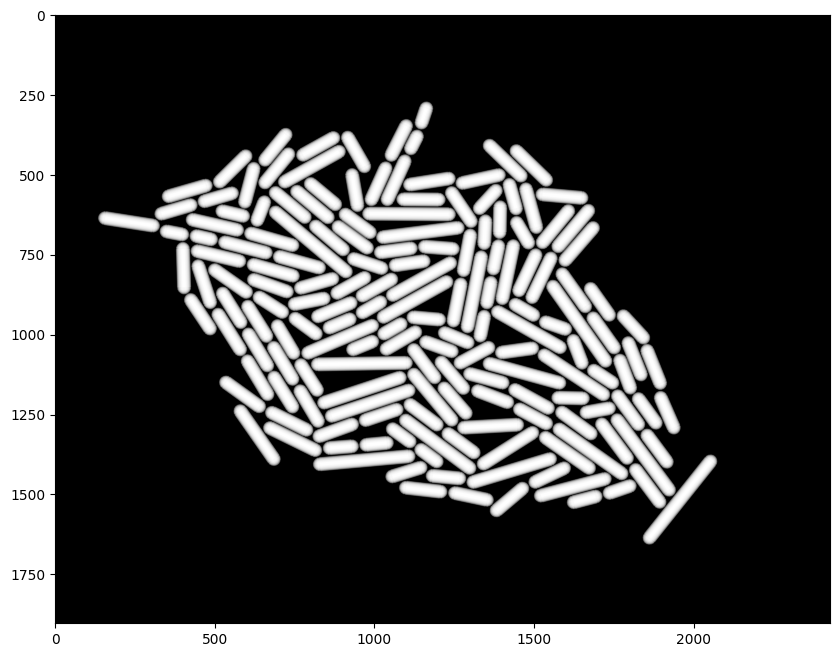

In [109]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(space, cmap="Greys_r")

In [110]:
shape = scene_shape
scale = 5
octaves = 10
persistence = 1.9
lacunarity = 1.8
def perlin_generator(scale, octaves, persistence, lacunarity, resize_amount):
    
    y, x = np.round(shape[0]/resize_amount).astype(int), np.round(shape[1]/resize_amount).astype(int)
    
    world = np.zeros((x,y))

    # make coordinate grid on [0,1]^2
    x_idx = np.linspace(0, 1, y)
    y_idx = np.linspace(0, 1, x)
    world_x, world_y = np.meshgrid(x_idx, y_idx)

    # apply perlin noise, instead of np.vectorize, consider using itertools.starmap()
    world = np.vectorize(noise.pnoise2)(world_x/scale,
                            world_y/scale,
                            octaves=octaves,
                            persistence=persistence,
                            lacunarity=lacunarity)

    # here was the error: one needs to normalize the image first. Could be done without copying the array, though
    img = np.floor((world + .5) * 255).astype(np.uint8) # <- Normalize world first
    return img

In [111]:
def random_perlin_generator():
    return perlin_generator(np.random.uniform(1,7), np.random.choice([10,11,12,13]), np.random.uniform(1,1.9), np.random.uniform(1.55,1.9), resize_amount=3)

In [112]:
bg = random_perlin_generator()

In [113]:
bg.shape

(809, 635)

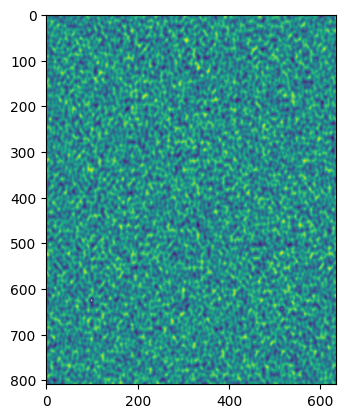

In [114]:
plt.imshow(bg)

In [115]:
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
from skimage.util import random_noise
from scipy.ndimage import gaussian_filter

from skimage.exposure import rescale_intensity


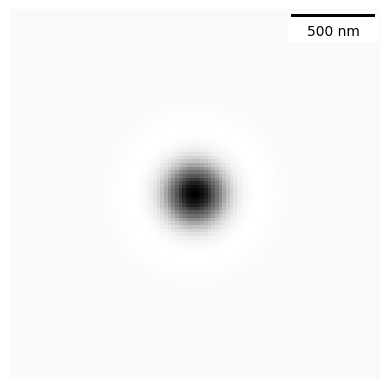

In [116]:
my_kernel = PSF_generator(
    radius = 50, 
    wavelength = 0.75, 
    NA = 1.45, 
    n = 1.4, 
    resize_amount = 3, 
    pix_mic_conv = 0.065, 
    apo_sigma = 10, 
    mode="phase contrast", 
    condenser = "Ph3")
my_kernel.calculate_PSF()
my_kernel.plot_PSF()

my_kernel.kernel += 0.00000014
temp_kernel = my_kernel.kernel
temp_kernel = gaussian_filter(temp_kernel, 8.7, mode="reflect")

In [117]:
scene = rescale_intensity(space, out_range=(0,1))
convolved = convolve_rescale(random_noise(scene, mode="gaussian", mean=0, var=np.random.uniform(0,0.05), clip=False), temp_kernel, 1/resize_amount, rescale_int = True)  + gaussian_filter(np.rot90(bg)/np.random.uniform(10000,15000), np.random.uniform(1,3), mode="reflect") 
convolved = random_noise((convolved), mode="poisson")
convolved = random_noise((convolved), mode="gaussian", mean=1, var=0.0002, clip=False)
convolved = rescale_intensity(convolved.astype(np.float32), out_range=(0,np.iinfo(np.uint16).max)).astype(np.uint16)


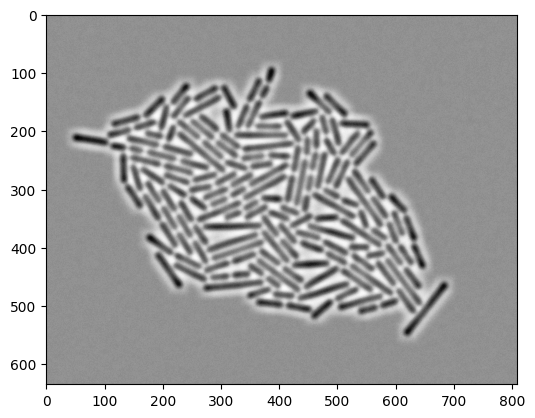

In [118]:
plt.imshow(convolved, cmap="Greys_r")